In [1]:

import tensorflow as tf, sys
print("Python:", sys.version.split()[0])
print("TensorFlow:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPU available:", len(gpus) > 0, "| GPU devices:", gpus)


Python: 3.12.12
TensorFlow: 2.19.0
GPU available: True | GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

!pip install -q kaggle

from google.colab import files
import os, shutil, glob

print("Upload your Kaggle token file (e.g. 'kaggle (4).json').")
uploaded = files.upload()
kaggle_file = None
for fname in uploaded.keys():
    if 'kaggle' in fname.lower() and fname.lower().endswith('.json'):
        kaggle_file = fname
        break

if kaggle_file is None:
    raise RuntimeError("No kaggle json uploaded. Please upload the file 'kaggle (4).json' (or any kaggle .json).")

kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)
dest = os.path.join(kaggle_dir, "kaggle.json")

if os.path.exists(dest):
    os.remove(dest)
shutil.move(kaggle_file, dest)
os.chmod(dest, 0o600)
print("Kaggle token installed to ~/.kaggle/kaggle.json")


Upload your Kaggle token file (e.g. 'kaggle (4).json').


Saving kaggle (18).json to kaggle (18).json
Kaggle token installed to ~/.kaggle/kaggle.json


In [ ]:

dataset_slug = "gunavenkatdoddi/eye-diseases-classification"


if os.path.exists("eye-diseases-classification.zip"):
    os.remove("eye-diseases-classification.zip")

print("Downloading dataset:", dataset_slug, " — this may take a moment.")

!kaggle datasets download -d {dataset_slug} -q || echo "kaggle download failed — check token/permission."


zip_files = glob.glob("/content/*.zip")
if not zip_files:
    raise RuntimeError("No zip file found in /content. Check Kaggle download step output above.")
zip_path = zip_files[0]
print("Found zip:", zip_path)


import zipfile
extract_root = "/content/dataset_extracted"
if os.path.exists(extract_root):
    shutil.rmtree(extract_root)
os.makedirs(extract_root, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_root)
print("Extracted dataset to:", extract_root)


Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
Found zip: /content/eye-diseases-classification.zip
Extracted dataset to: /content/dataset_extracted


In [ ]:

import os

def contains_image_files(path):
    try:
        for f in os.listdir(path):
            if f.lower().endswith(('.jpg','.jpeg','.png')):
                return True
    except Exception:
        return False
    return False

def find_dataset_dir(root):

    children = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]

    img_count = sum(1 for c in children if contains_image_files(c))
    if img_count >= 2:
        return root

    for dirpath, dirnames, filenames in os.walk(root):
        child_dirs = [os.path.join(dirpath, d) for d in os.listdir(dirpath) if os.path.isdir(os.path.join(dirpath,d))]
        cnt = 0
        for s in child_dirs:
            if contains_image_files(s):
                cnt += 1
        if cnt >= 2:
            return dirpath
    return None

root = "/content/dataset_extracted"
dataset_dir = find_dataset_dir(root)
if dataset_dir is None:

    if os.path.exists("/content/dataset"):
        dataset_dir = "/content/dataset"
    else:
        print("Could not auto-find dataset folder. Listing extracted content for debugging:")
        !ls -R /content/dataset_extracted
        raise RuntimeError("Dataset folder not found automatically. Inspect the listing above.")
else:
    print("Detected dataset directory:", dataset_dir)

final_dataset = "/content/dataset"

if os.path.exists(final_dataset):
    print("Cleaning existing /content/dataset ...")
    shutil.rmtree(final_dataset)
os.makedirs(final_dataset, exist_ok=True)


moved = 0
for entry in os.listdir(dataset_dir):
    s = os.path.join(dataset_dir, entry)
    if os.path.isdir(s):

        shutil.move(s, final_dataset)
        moved += 1

if moved == 0:
    raise RuntimeError(f"No class folders found under {dataset_dir} to move into {final_dataset}.")
print(f"Moved {moved} class folders into {final_dataset}")

print("Final /content/dataset contents:")
!ls -1 /content/dataset


Detected dataset directory: /content/dataset_extracted/dataset
Moved 4 class folders into /content/dataset
Final /content/dataset contents:
cataract
diabetic_retinopathy
glaucoma
normal


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATASET_PATH = "/content/dataset"
print("Using dataset path:", DATASET_PATH)
print("Top-level folders (classes):", sorted(os.listdir(DATASET_PATH)))

IMG_SIZE = (224,224)
BATCH = 32
VAL_SPLIT = 0.15

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=18,
    zoom_range=0.12,
    horizontal_flip=True,
    validation_split=VAL_SPLIT
)

train_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

class_indices = train_gen.class_indices
num_classes = len(class_indices)
print("Detected classes (name -> index):", class_indices)
print("Number of classes:", num_classes)


Using dataset path: /content/dataset
Top-level folders (classes): ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Found 3586 images belonging to 4 classes.
Found 631 images belonging to 4 classes.
Detected classes (name -> index): {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}
Number of classes: 4


In [ ]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

base = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))
base.trainable = False  # freeze weights

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
out = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base.input, outputs=out)
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', verbose=1)
]

EPOCHS = 8
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.4202 - loss: 1.2476
Epoch 1: val_loss improved from inf to 0.97920, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 102s 777ms/step - accuracy: 0.4210 - loss: 1.2463 - val_accuracy: 0.5705 - val_loss: 0.9792
Epoch 2/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.6320 - loss: 0.8821
Epoch 2: val_loss improved from 0.97920 to 0.81456, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 639ms/step - accuracy: 0.6322 - loss: 0.8818 - val_accuracy: 0.6846 - val_loss: 0.8146
Epoch 3/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.7091 - loss: 0.7409
Epoch 3: val_loss improved from 0.81456 to 0.81112, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 637ms/step - accuracy: 0.7091 - loss: 0.7408 - val_accuracy: 0.6656 - val_loss: 0.8111
Epoch 4/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.7400 - loss: 0.6672
Epoch 4: val_loss improved from 0.81112 to 0.72464, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 634ms/step - accuracy: 0.7400 - loss: 0.6672 - val_accuracy: 0.7147 - val_loss: 0.7246
Epoch 5/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.7426 - loss: 0.6436
Epoch 5: val_loss improved from 0.72464 to 0.72083, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 632ms/step - accuracy: 0.7426 - loss: 0.6435 - val_accuracy: 0.6989 - val_loss: 0.7208
Epoch 6/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.7603 - loss: 0.6380
Epoch 6: val_loss improved from 0.72083 to 0.67748, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 71s 627ms/step - accuracy: 0.7603 - loss: 0.6379 - val_accuracy: 0.7195 - val_loss: 0.6775
Epoch 7/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.7683 - loss: 0.6008
Epoch 7: val_loss did not improve from 0.67748
113/113 ━━━━━━━━━━━━━━━━━━━━ 70s 619ms/step - accuracy: 0.7683 - loss: 0.6007 - val_accuracy: 0.6894 - val_loss: 0.7572
Epoch 8/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.7644 - loss: 0.6121
Epoch 8: val_loss did not improve from 0.67748
113/113 ━━━━━━━━━━━━━━━━━━━━ 70s 619ms/step - accuracy: 0.7645 - loss: 0.6117 - val_accuracy: 0.7147 - val_loss: 0.6862
Restoring model weights from the end of the best epoch: 6.


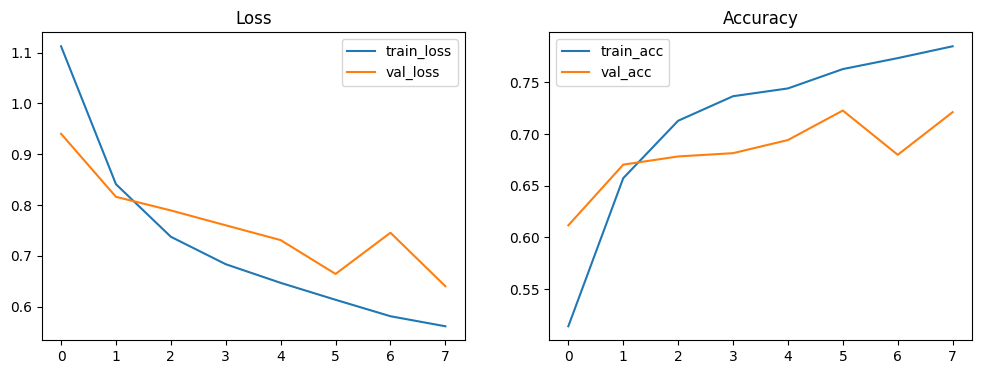

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 487ms/step
Labels (index order): ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


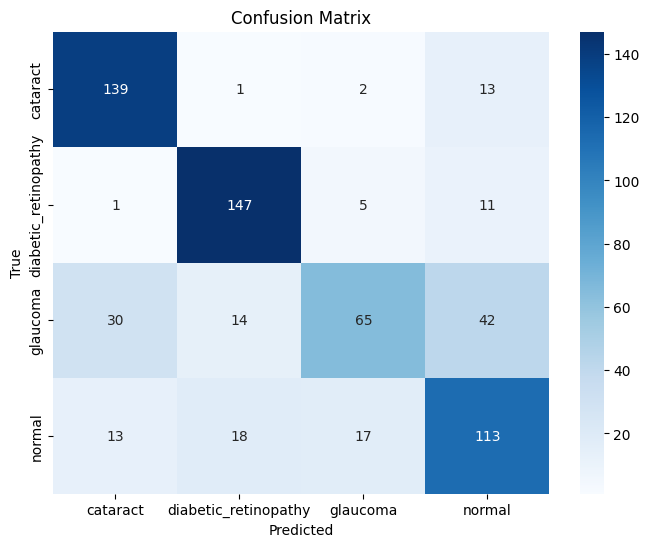

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.76      0.90      0.82       155
diabetic_retinopathy       0.82      0.90      0.85       164
            glaucoma       0.73      0.43      0.54       151
              normal       0.63      0.70      0.66       161

            accuracy                           0.74       631
           macro avg       0.73      0.73      0.72       631
        weighted avg       0.73      0.74      0.72       631



In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title("Accuracy")
plt.show()


val_steps = int(np.ceil(val_gen.samples / val_gen.batch_size))
y_true = val_gen.classes
y_probs = model.predict(val_gen, steps=val_steps, verbose=1)
y_pred = np.argmax(y_probs, axis=1)


cm = confusion_matrix(y_true, y_pred)

labels = [k for k,v in sorted(class_indices.items(), key=lambda item: item[1])]
print("Labels (index order):", labels)
plt.figure(figsize=(8,6))
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))


In [ ]:

index_to_disease = {v: k.strip() for k,v in class_indices.items()}
print("Index -> Disease mapping:", index_to_disease)


Index -> Disease mapping: {0: 'cataract', 1: 'diabetic_retinopathy', 2: 'glaucoma', 3: 'normal'}


In [ ]:



doctor_data = [
    {"name": "Dr. Mehta", "specialization": "Ophthalmologist", "experience": 15, "fee": 800, "success_rate": 96},
    {"name": "Dr. Sharma", "specialization": "Eye Surgeon", "experience": 12, "fee": 900, "success_rate": 92},
    {"name": "Dr. Nair", "specialization": "Optometrist", "experience": 10, "fee": 600, "success_rate": 88},
    {"name": "Dr. Khan", "specialization": "Retina Specialist", "experience": 14, "fee": 1000, "success_rate": 95},
    {"name": "Dr. Gupta", "specialization": "Ophthalmologist", "experience": 8, "fee": 700, "success_rate": 85},
]

disease_specialization = {
    "Bulging Eyes": "Ophthalmologist",
    "Cataracts": "Eye Surgeon",
    "Crossed Eyes": "Optometrist",
    "Glaucoma": "Retina Specialist",
    "Uveitis": "Ophthalmologist",
}

def recommend_doctors_for_disease(disease, top_k=3):
    if disease not in disease_specialization:
        print(f"Error: Disease '{disease}' not found in mapping!")
        return None, []

    specialization = disease_specialization[disease]
    doctors = [d for d in doctor_data if d["specialization"] == specialization]
    sorted_docs = sorted(doctors, key=lambda x: (x["success_rate"], x["experience"]), reverse=True)
    return specialization, sorted_docs[:top_k]


In [ ]:


index_to_disease = {
    0: "Bulging Eyes",
    1: "Cataracts",
    2: "Crossed Eyes",
    3: "Glaucoma",
    4: "Uveitis"
}


In [ ]:



from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

print("Upload an eye image to test the pipeline (jpg/png).")
uploaded = files.upload()

if not uploaded:
    print("No image uploaded. You can also test using validation images (val_gen.filepaths).")
else:
    img_name = list(uploaded.keys())[0]
    img_path = img_name
    img = image.load_img(img_path, target_size=IMG_SIZE)
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, 0)
    preds = model.predict(arr)
    idx = int(np.argmax(preds, axis=1)[0])
    disease = index_to_disease.get(idx, "Unknown").strip()
    prob = float(np.max(preds))
    print(f"Predicted disease: {disease}  (confidence: {prob:.3f})")

    spec, top_docs = recommend_doctors_for_disease(disease, top_k=3)
    print("Mapped specialization:", spec)
    print("Top recommended doctors:")
    for d in top_docs:
        print(f" - {d['name']} ({d['specialization']}), Exp: {d['experience']} yrs, Fees: ₹{d['fee']}, Success: {d['success_rate']}%")


Upload an eye image to test the pipeline (jpg/png).


Saving eye1.jpeg to eye1.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted disease: Cataracts  (confidence: 0.990)
Mapped specialization: Eye Surgeon
Top recommended doctors:
 - Dr. Sharma (Eye Surgeon), Exp: 12 yrs, Fees: ₹900, Success: 92%
